# Задача 5

### Обработка данных

In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as st
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from PIL import Image
from matplotlib.pyplot import imshow
import copy
%matplotlib inline

In [2]:
X_train = np.load('regression_x_train.npy')
y_train = np.load('regression_y_train.npy')
X_test = np.load('regression_x_test.npy')

In [3]:
X_train.shape, y_train.shape, X_test.shape

((286, 604, 35), (286, 604), (420, 620, 35))

Обучающая выборка -  изображение 286х604. В X_train для каждого из пикселей изображения есть 35 признаков, в y_train эти пиксели восстановлены.

Приведем данные к более удобному формату (преобразуем матрицу в столбец):

In [4]:
# all pixels -> one line
def linearize(data):
    if len(data.shape) > 2:
        return data.reshape(-1, data.shape[-1])
    else:
        return data.flatten()

# gets matrix from 1d-array
def get_image(n, m, data):
    assert n*m == len(data), 'Wrong image size: {}*{} != {}'.format(n, m, len(data))
    if len(data.shape) > 1:
        return data.reshape(n, m, -1)
    else:
        return data.reshape(n, m)

In [5]:
X_train, y_train, X_test = linearize(X_train), linearize(y_train), linearize(X_test)

In [6]:
X_train, y_train, X_test = pd.DataFrame(X_train), pd.DataFrame(y_train), pd.DataFrame(X_test)

In [7]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,0.496714,-0.138264,1.647689,2.288549,0.859431,-0.070241,0.473764,1.23023,0.624677,1.256353,...,138.643103,45.607623,38.750030,147.605407,252.427767,-0.601707,1.852278,-0.013497,-1.057711,0.822545
1,0.496714,-0.138264,1.647689,2.293655,-0.079660,-0.070241,0.473764,1.23023,0.629783,0.317261,...,139.352788,17.831804,15.150602,57.711200,98.694957,-0.601707,1.852278,-0.013497,-1.057711,0.822545
2,0.496714,-0.138264,1.647689,2.296195,1.243614,-0.070241,0.473764,1.23023,0.632323,1.640535,...,139.707226,66.970839,56.901059,216.745739,370.668282,-0.601707,1.852278,-0.013497,-1.057711,0.822545
3,0.496714,-0.138264,1.647689,2.296195,0.714635,-0.070241,0.473764,1.23023,0.632323,1.111556,...,139.707226,39.459637,33.526459,127.707943,218.400068,-0.601707,1.852278,-0.013497,-1.057711,0.822545
4,0.496714,-0.138264,1.647689,2.288549,0.422087,-0.070241,0.473764,1.23023,0.624677,0.819008,...,138.643103,29.451076,25.022793,95.316041,163.004973,-0.601707,1.852278,-0.013497,-1.057711,0.822545


In [8]:
X_train.info() # пропусков нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172744 entries, 0 to 172743
Data columns (total 35 columns):
0     172744 non-null float64
1     172744 non-null float64
2     172744 non-null float64
3     172744 non-null float64
4     172744 non-null float64
5     172744 non-null float64
6     172744 non-null float64
7     172744 non-null float64
8     172744 non-null float64
9     172744 non-null float64
10    172744 non-null float64
11    172744 non-null float64
12    172744 non-null float64
13    172744 non-null float64
14    172744 non-null float64
15    172744 non-null float64
16    172744 non-null float64
17    172744 non-null float64
18    172744 non-null float64
19    172744 non-null float64
20    172744 non-null float64
21    172744 non-null float64
22    172744 non-null float64
23    172744 non-null float64
24    172744 non-null float64
25    172744 non-null float64
26    172744 non-null float64
27    172744 non-null float64
28    172744 non-null float64
29    172744 non-nu

In [9]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
count,172744.000000,172744.000000,172744.000000,172744.000000,172744.000000,172744.000000,172744.000000,172744.000000,172744.000000,172744.000000,...,172744.000000,172744.000000,172744.000000,172744.000000,172744.000000,1.727440e+05,1.727440e+05,1.727440e+05,1.727440e+05,1.727440e+05
mean,0.545034,0.345932,1.115172,2.280180,0.208698,-0.021921,0.957960,0.697714,0.616308,0.605619,...,156.440633,29.091510,24.717291,94.152333,161.014855,-6.017066e-01,1.852278e+00,-1.349722e-02,-1.057711e+00,8.225449e-01
std,0.214442,0.499752,0.498943,0.454953,0.531401,0.214442,0.499752,0.498943,0.454953,0.531401,...,118.629434,29.814209,25.331324,96.491291,165.014829,2.220452e-16,8.881810e-16,8.673642e-18,2.220452e-16,5.551131e-16
min,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.070241,0.473764,0.230230,-0.140842,0.162768,...,64.481856,15.279169,12.981782,49.449801,84.566704,-6.017066e-01,1.852278e+00,-1.349722e-02,-1.057711e+00,8.225449e-01
25%,0.496714,-0.138264,0.647689,2.068197,-0.123264,-0.070241,0.473764,0.230230,0.404325,0.273657,...,111.224538,17.070970,14.504168,55.248823,94.483917,-6.017066e-01,1.852278e+00,-1.349722e-02,-1.057711e+00,8.225449e-01
50%,0.496714,-0.138264,0.647689,2.286654,-0.028051,-0.070241,0.473764,0.230230,0.622782,0.368870,...,138.380597,18.776245,15.953036,60.767808,103.922223,-6.017066e-01,1.852278e+00,-1.349722e-02,-1.057711e+00,8.225449e-01
75%,0.496714,0.861736,1.647689,2.392652,0.386209,-0.070241,1.473764,1.230230,0.728780,0.783130,...,153.854337,28.413168,24.140945,91.956936,157.260390,-6.017066e-01,1.852278e+00,-1.349722e-02,-1.057711e+00,8.225449e-01
max,1.496714,0.861736,1.647689,6.026687,4.239442,0.929759,1.473764,1.230230,4.362815,4.636364,...,5825.737651,1339.546129,1138.131074,4335.333396,7414.081558,-6.017066e-01,1.852278e+00,-1.349722e-02,-1.057711e+00,8.225449e-01


#### Посмотрим на распределение признаков:

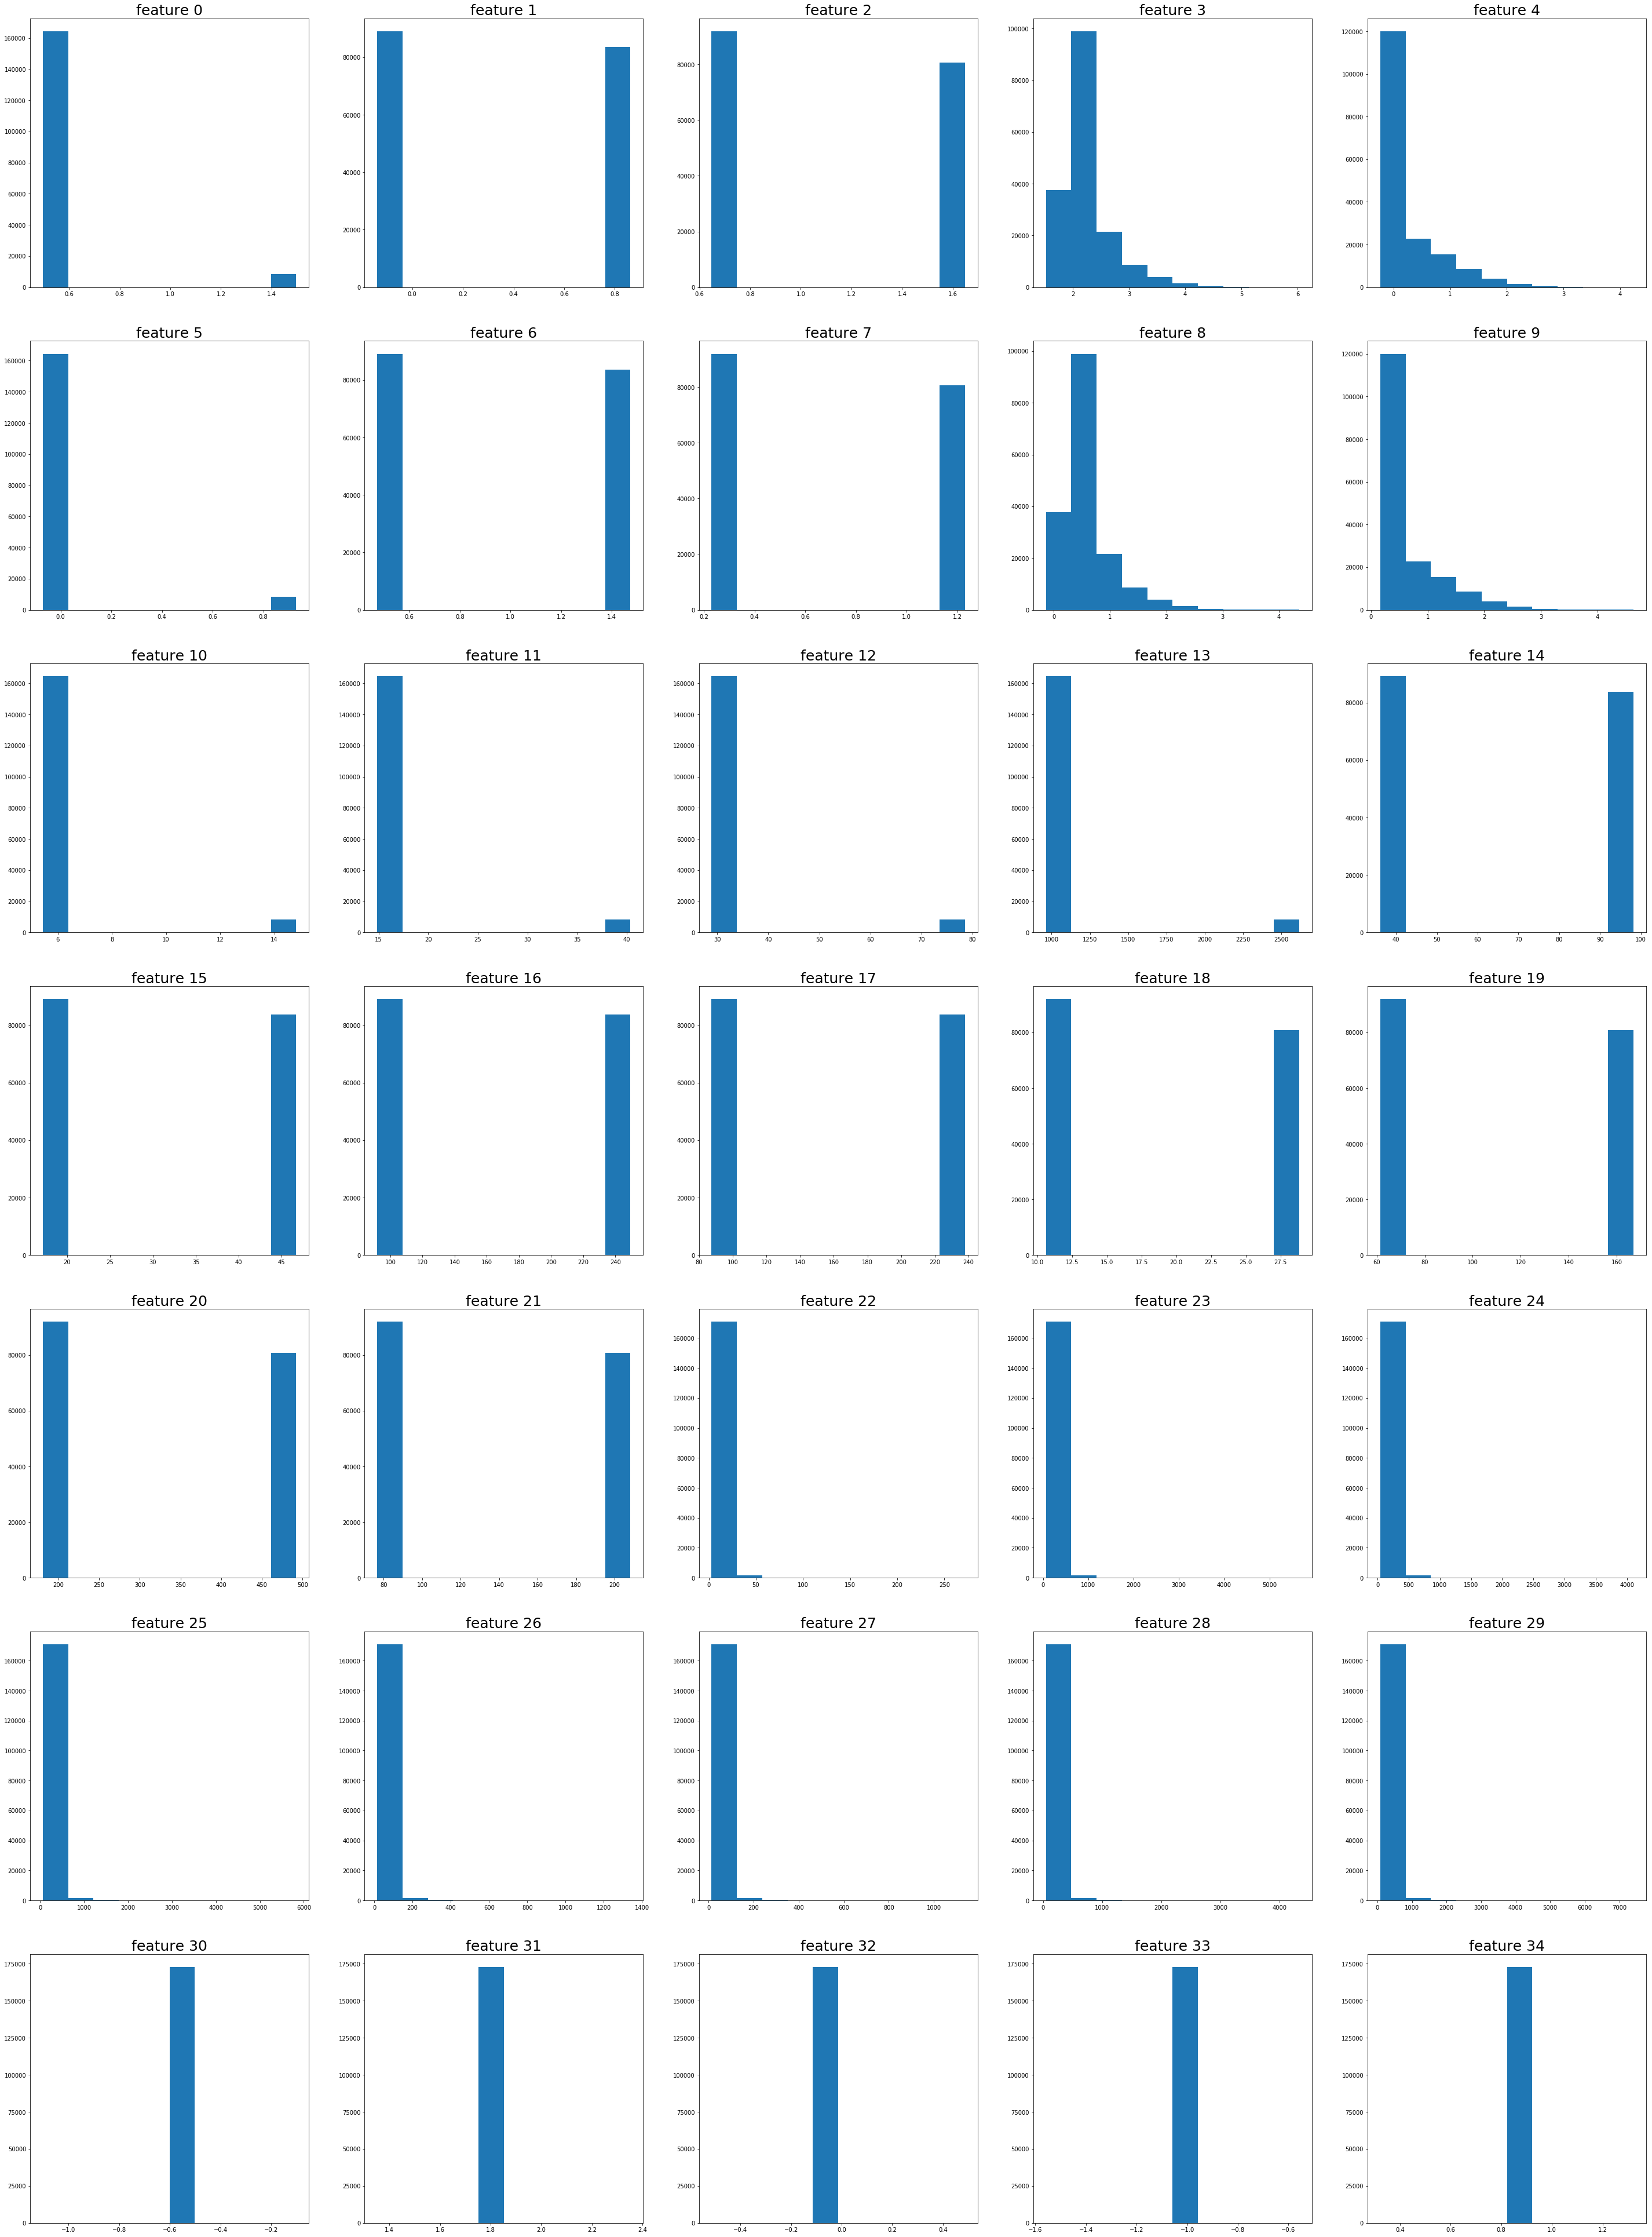

In [10]:
fig, axs = plt.subplots(7, 5, figsize=(50, 70))
for i in range(7):
    for j in range(5):
        axs[i, j].hist(X_train[i*5+j].values)
        axs[i, j].set_title('feature '+str(i*5+j), fontsize=25)

In [11]:
def same(a):
    return (a == a[0]).all()

for i in range(30, 35):
    assert same(X_train[i])

Последние 5 признаков неинформативны.

In [12]:
delete = np.arange(30, 35)

In [13]:
#X_train.drop(columns=np.arange(30, 35), inplace=True)
#X_test.drop(columns=np.arange(30, 35), inplace=True)

В оставшихся признаках удалим выбросы и зависимые признаки. Так как признаков очень много, будем рассматривать группы с похожими распределениями.

Посмотрим на признаки 0, 5, 10-13, 22-29. Число различных элементов в каждом:

In [14]:
cols = [0, 5, 10, 11, 12, 13, 22, 23, 24, 25, 26, 27, 28, 29]
for i in cols:
    print(len(set(X_train[i].values)))

2
2
2
2
2
2
98899
98899
98899
98899
100611
100611
100611
100611


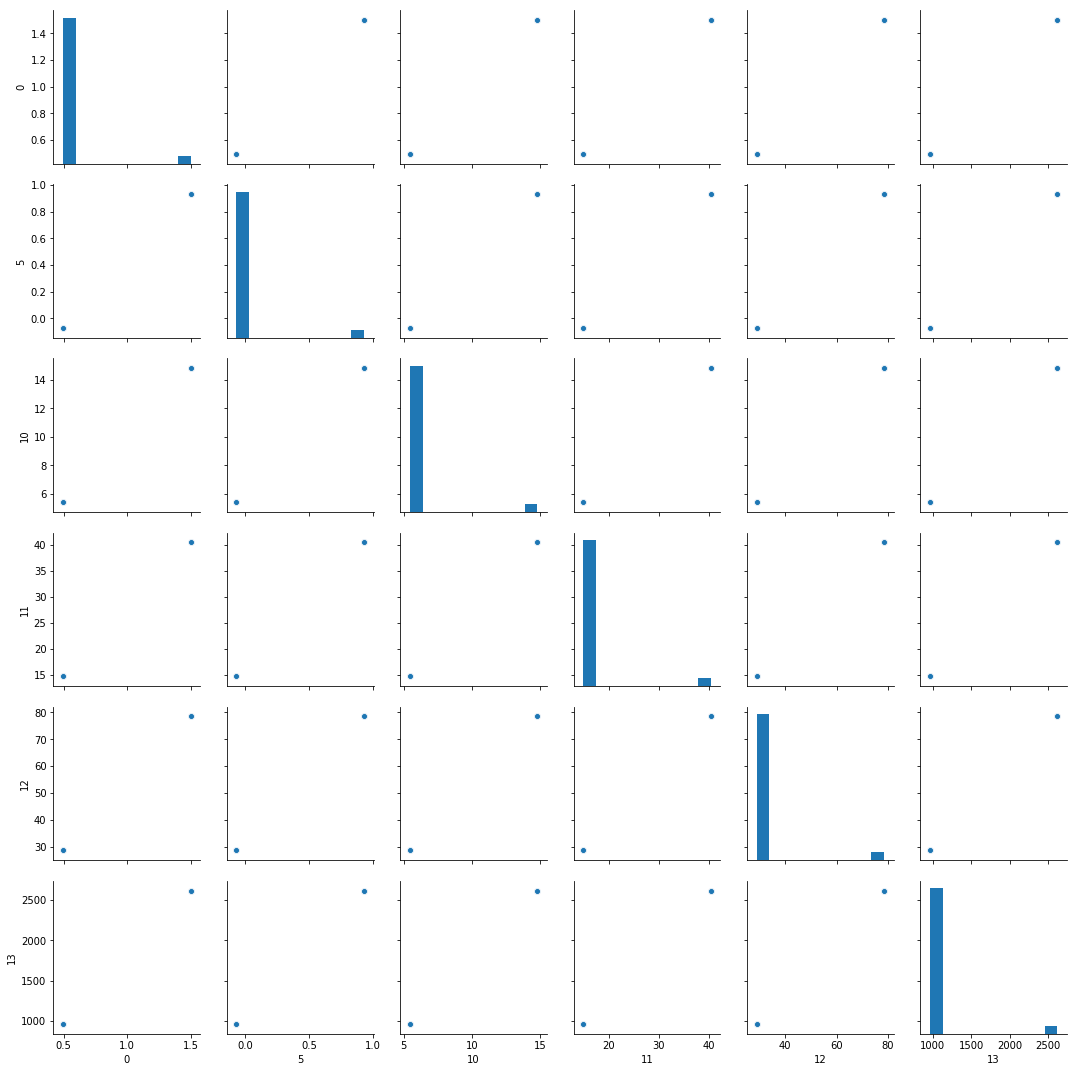

In [15]:
sns.pairplot(X_train[[0, 5, 10, 11, 12, 13]])

In [16]:
X_train[[0, 5, 10, 11, 12, 13]].corr()

,0,5,10,11,12,13
0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,1.0
10,1.0,1.0,1.0,1.0,1.0,1.0
11,1.0,1.0,1.0,1.0,1.0,1.0
12,1.0,1.0,1.0,1.0,1.0,1.0
13,1.0,1.0,1.0,1.0,1.0,1.0


In [17]:
cols = [5, 10, 11, 12, 13]
delete = np.append(delete, cols)
#X_train.drop(columns=cols, inplace=True)
#X_test.drop(columns=cols, inplace=True)

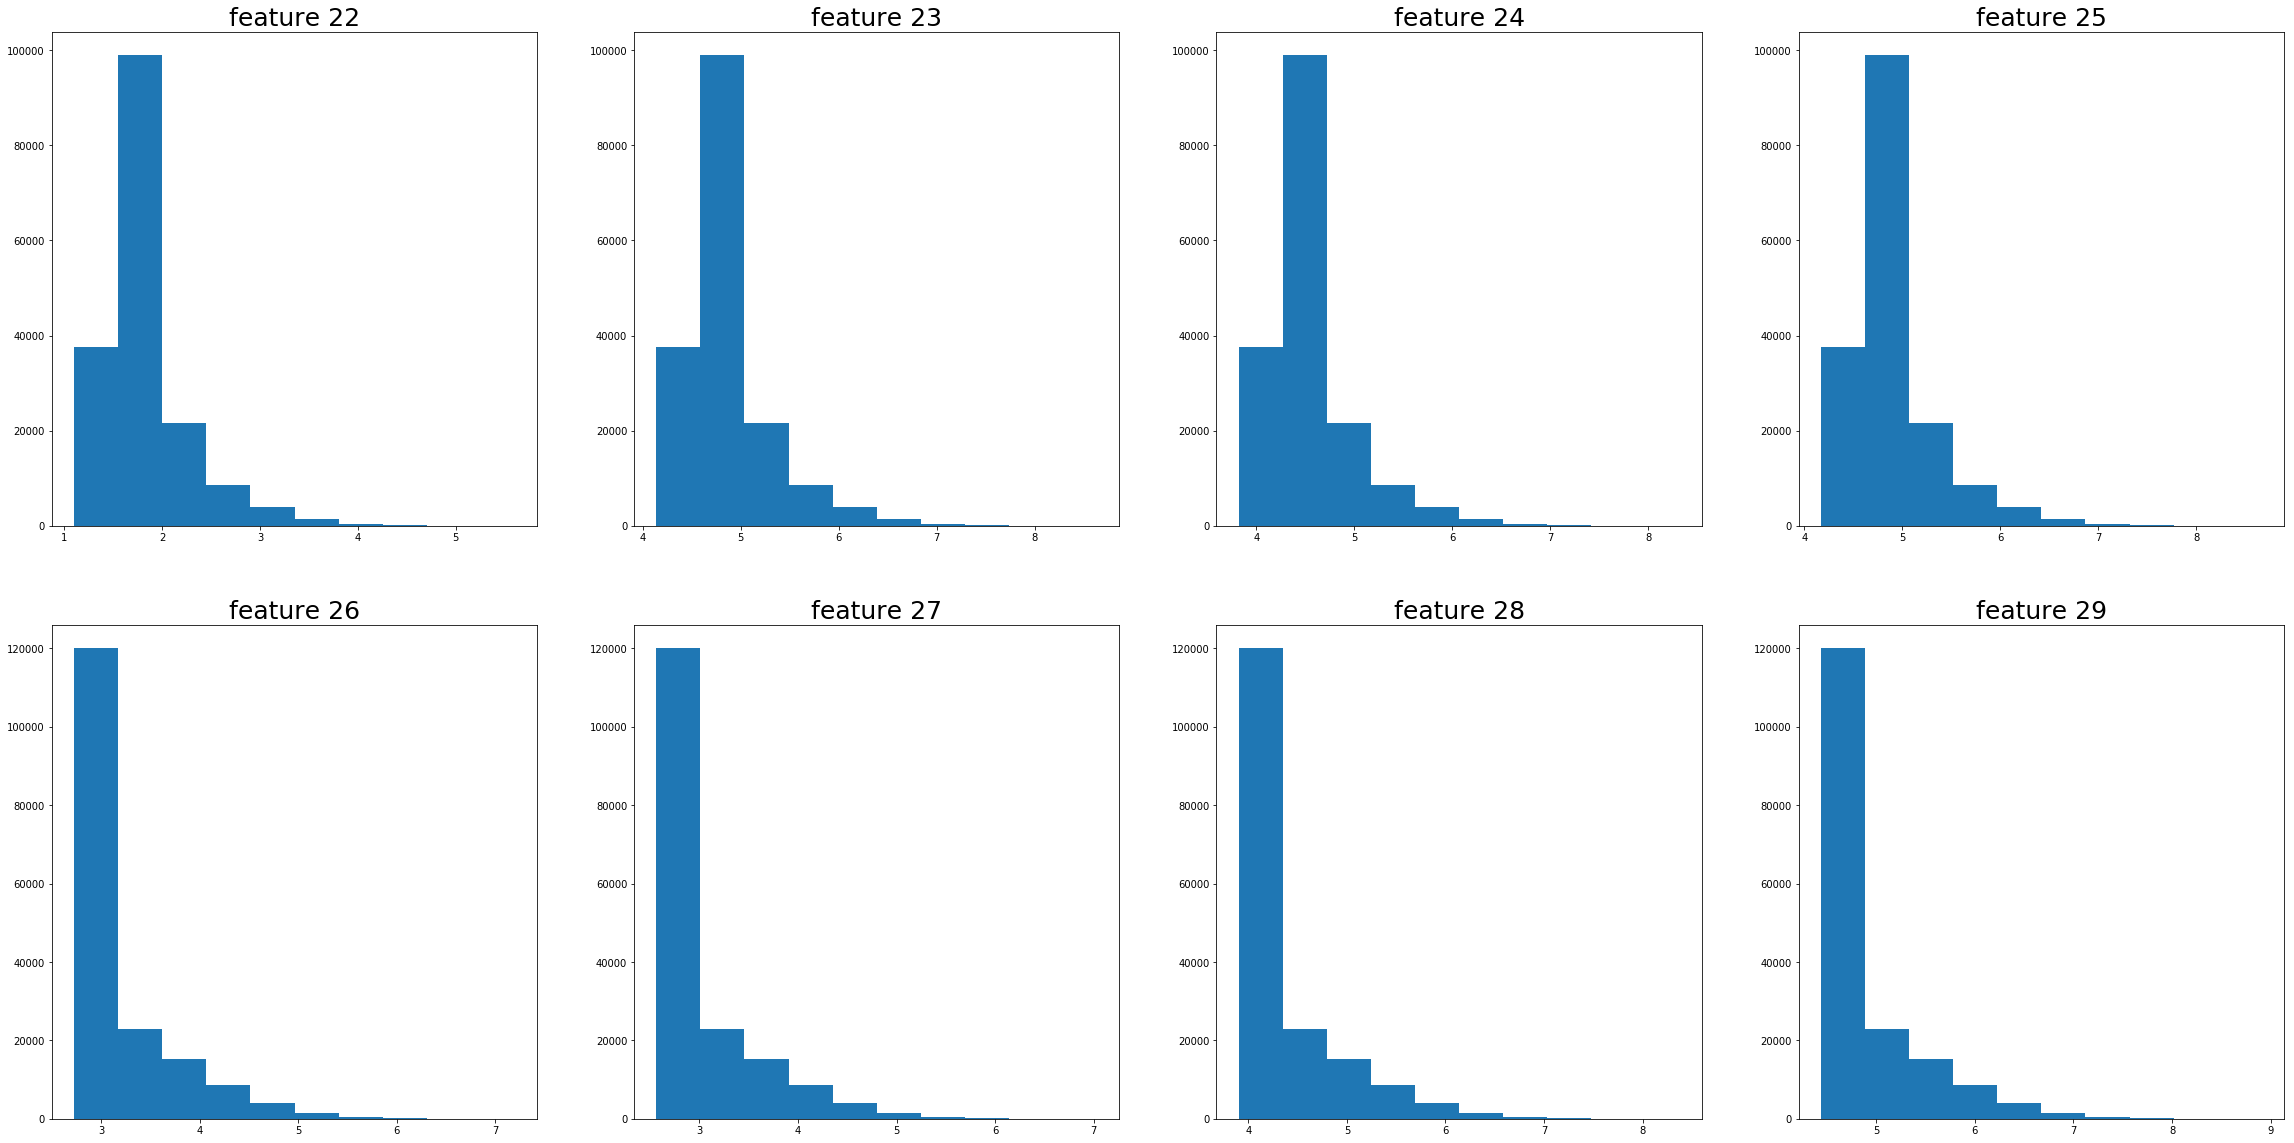

In [18]:
cols = [22, 23, 24, 25, 26, 27, 28, 29]

fig, axs = plt.subplots(2, 4, figsize=(40, 20))
for i in range(2):
    for j in range(4):
        axs[i, j].hist(np.log(X_train[cols[i*4+j]].values))
        axs[i, j].set_title('feature '+str(cols[i*4+j]), fontsize=25)

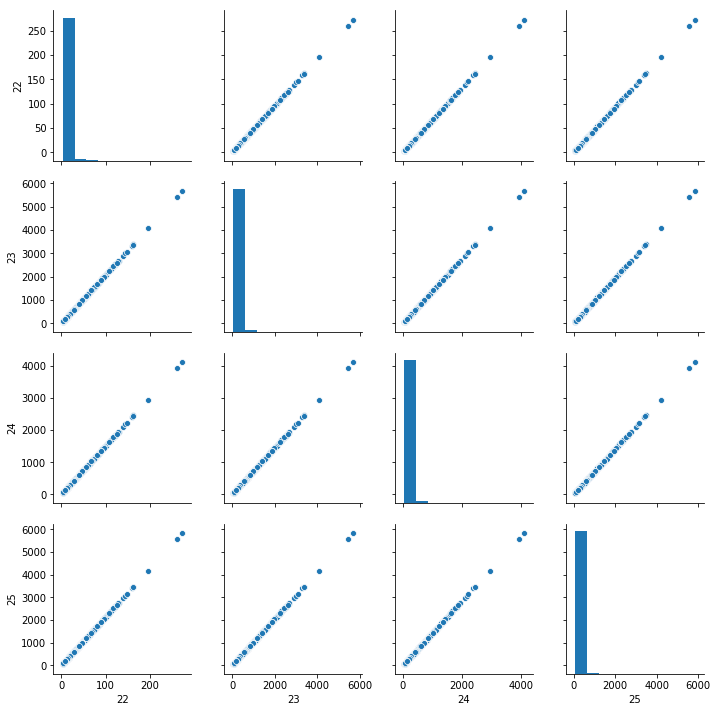

In [19]:
sns.pairplot(X_train[[22, 23, 24, 25]])

In [20]:
X_train[[22, 23, 24, 25]].corr()

,22,23,24,25
22,1.0,1.0,1.0,1.0
23,1.0,1.0,1.0,1.0
24,1.0,1.0,1.0,1.0
25,1.0,1.0,1.0,1.0


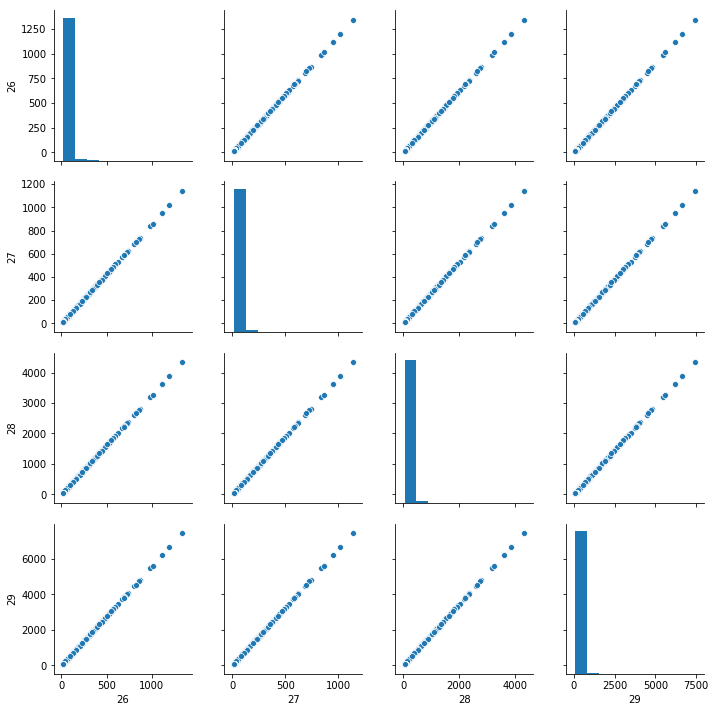

In [21]:
sns.pairplot(X_train[[26, 27, 28, 29]])

In [22]:
X_train[[26, 27, 28, 29]].corr()

,26,27,28,29
26,1.0,1.0,1.0,1.0
27,1.0,1.0,1.0,1.0
28,1.0,1.0,1.0,1.0
29,1.0,1.0,1.0,1.0


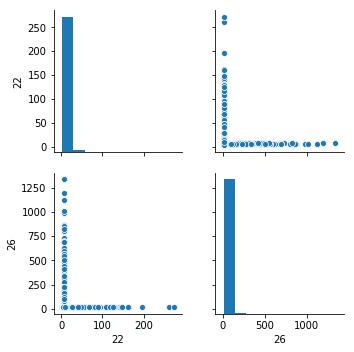

In [23]:
sns.pairplot(X_train[[22, 26]])

In [24]:
X_train[[22, 26]].corr()

,22,26
22,1.000000,-0.039822
26,-0.039822,1.000000


Видно, что из каждой из первых двух групп можно оставить один признак.

In [25]:
delete = np.append(delete, [23, 24, 25, 27, 28, 29])
#X_train.drop(columns=[23, 24, 25, 27, 28, 29], inplace=True)
#X_test.drop(columns=[23, 24, 25, 27, 28, 29], inplace=True)

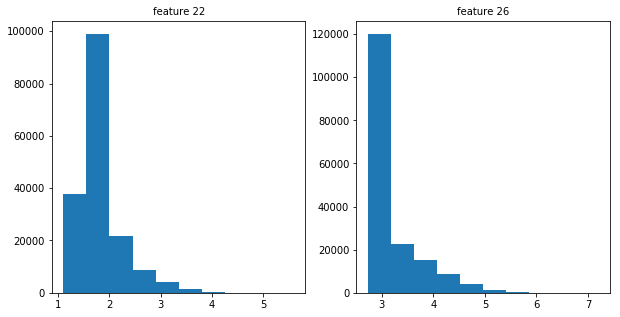

In [26]:
cols = [22, 26]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i in range(2):
    axs[i].hist(np.log(X_train[cols[i]].values))
    axs[i].set_title('feature '+str(cols[i]), fontsize=10)

Для признаков 3, 4, 8, 9: 

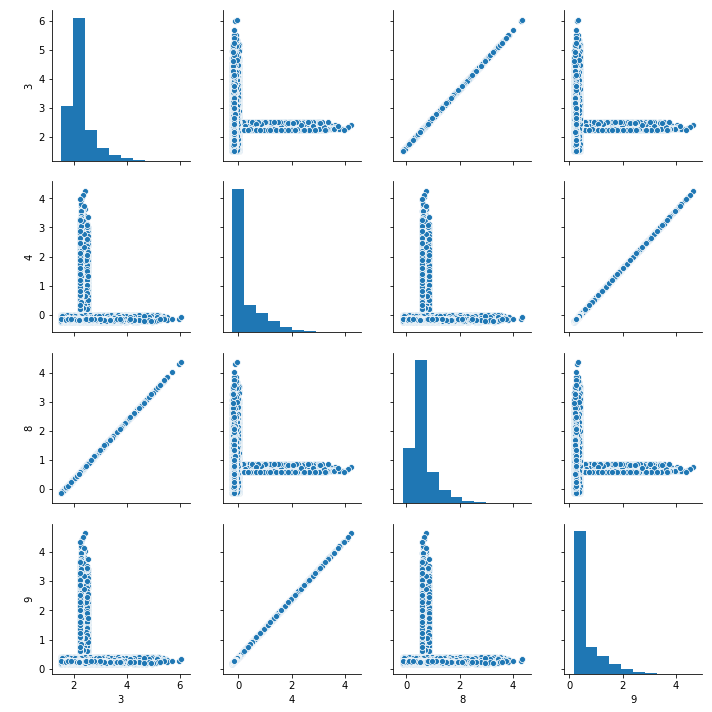

In [27]:
sns.pairplot(X_train[[3, 4, 8, 9]])

In [28]:
X_train[[3, 4, 8, 9]].corr()

,3,4,8,9
3,1.000000,0.071132,1.000000,0.071132
4,0.071132,1.000000,0.071132,1.000000
8,1.000000,0.071132,1.000000,0.071132
9,0.071132,1.000000,0.071132,1.000000


In [29]:
delete = np.append(delete, [8, 9])
#X_train.drop(columns=[8, 9], inplace=True)
#X_test.drop(columns=[8, 9], inplace=True)

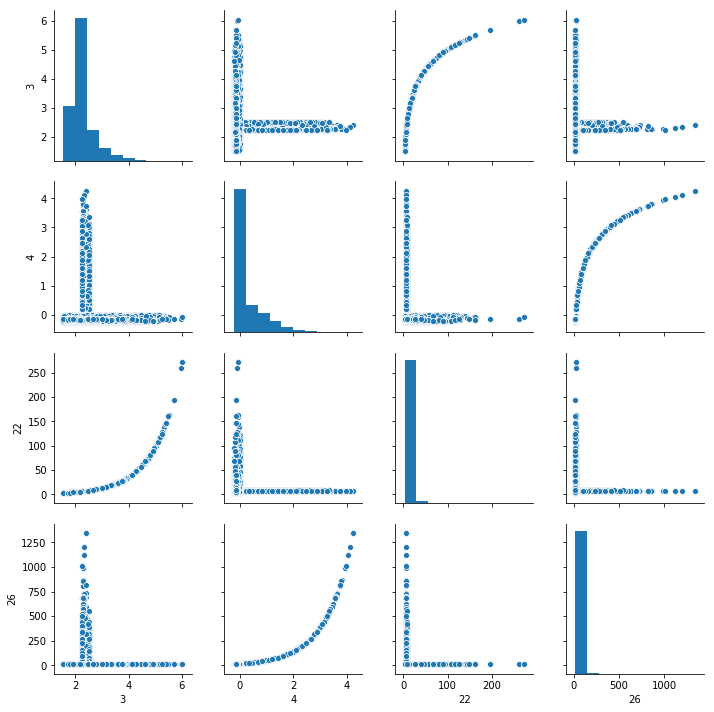

In [30]:
sns.pairplot(X_train[[3, 4, 22, 26]])

In [31]:
X_train[[3, 4, 22, 26]].corr()

,3,4,22,26
3,1.000000,0.071132,0.852357,0.039641
4,0.071132,1.000000,-0.053585,0.872005
22,0.852357,-0.053585,1.000000,-0.039822
26,0.039641,0.872005,-0.039822,1.000000


Зависимости 3-22, 4-26 почти линейные (высокая корреляция признаков). Можно попробовать удалить 22 и 26.

In [32]:
delete = np.append(delete, [22, 26])
#X_train.drop(columns=[22, 26], inplace=True)
#X_test.drop(columns=[22, 26], inplace=True)

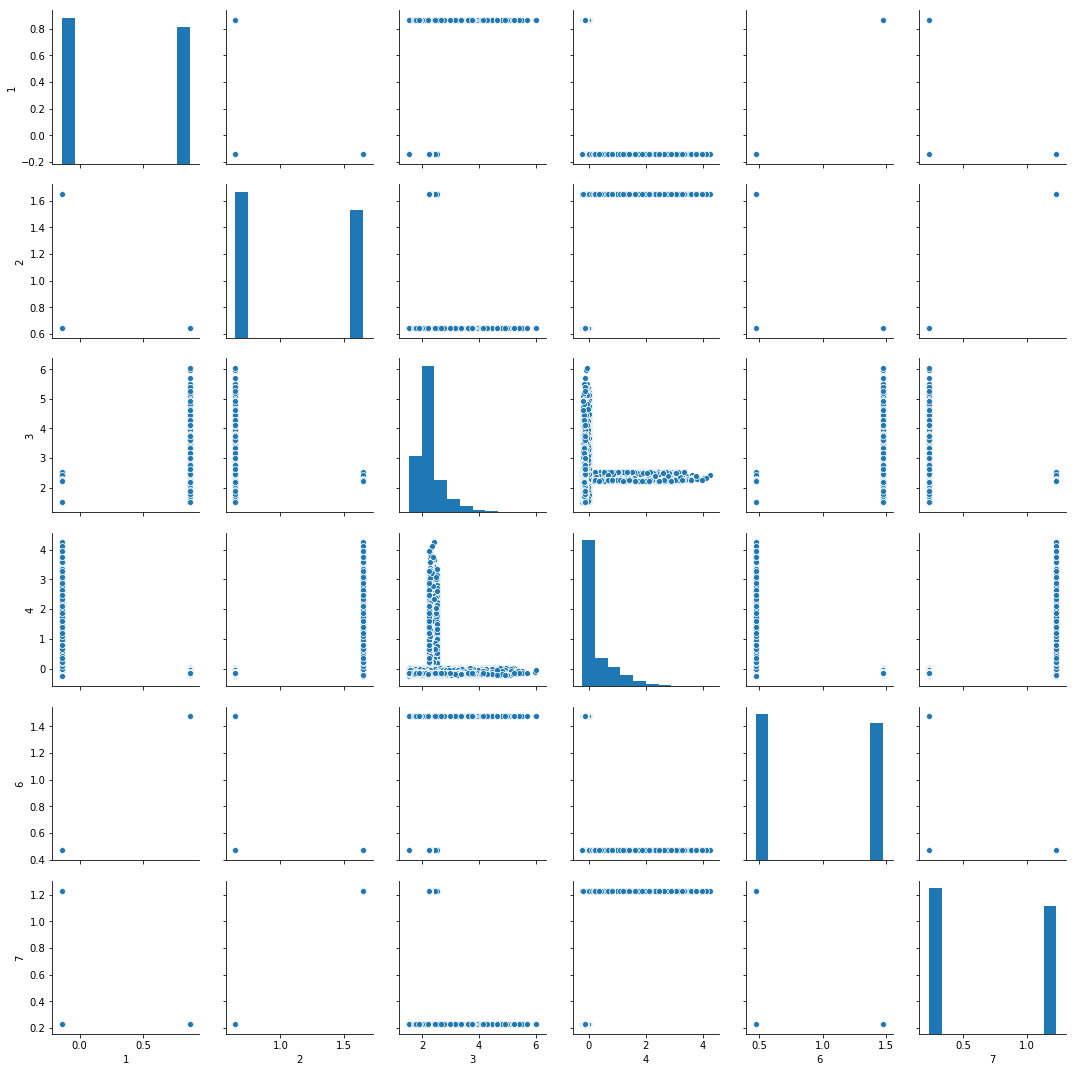

In [33]:
sns.pairplot(X_train[[1, 2, 3, 4, 6, 7]])

In [34]:
X_train[[1, 2, 3, 4, 6, 7]].corr()

,1,2,3,4,6,7
1,1.000000,-0.90779,0.080294,-0.542524,1.000000,-0.90779
2,-0.907790,1.00000,0.080750,0.624110,-0.907790,1.00000
3,0.080294,0.08075,1.000000,0.071132,0.080294,0.08075
4,-0.542524,0.62411,0.071132,1.000000,-0.542524,0.62411
6,1.000000,-0.90779,0.080294,-0.542524,1.000000,-0.90779
7,-0.907790,1.00000,0.080750,0.624110,-0.907790,1.00000


1-6, 2-7 - однозначная зависимость. 1-2 - высокая корреляция, 2-4 - заметная корреляция.

In [35]:
delete = np.append(delete, [2, 6, 7])
#X_train.drop(columns=[2, 6, 7], inplace=True)
#X_test.drop(columns=[2, 6, 7], inplace=True)

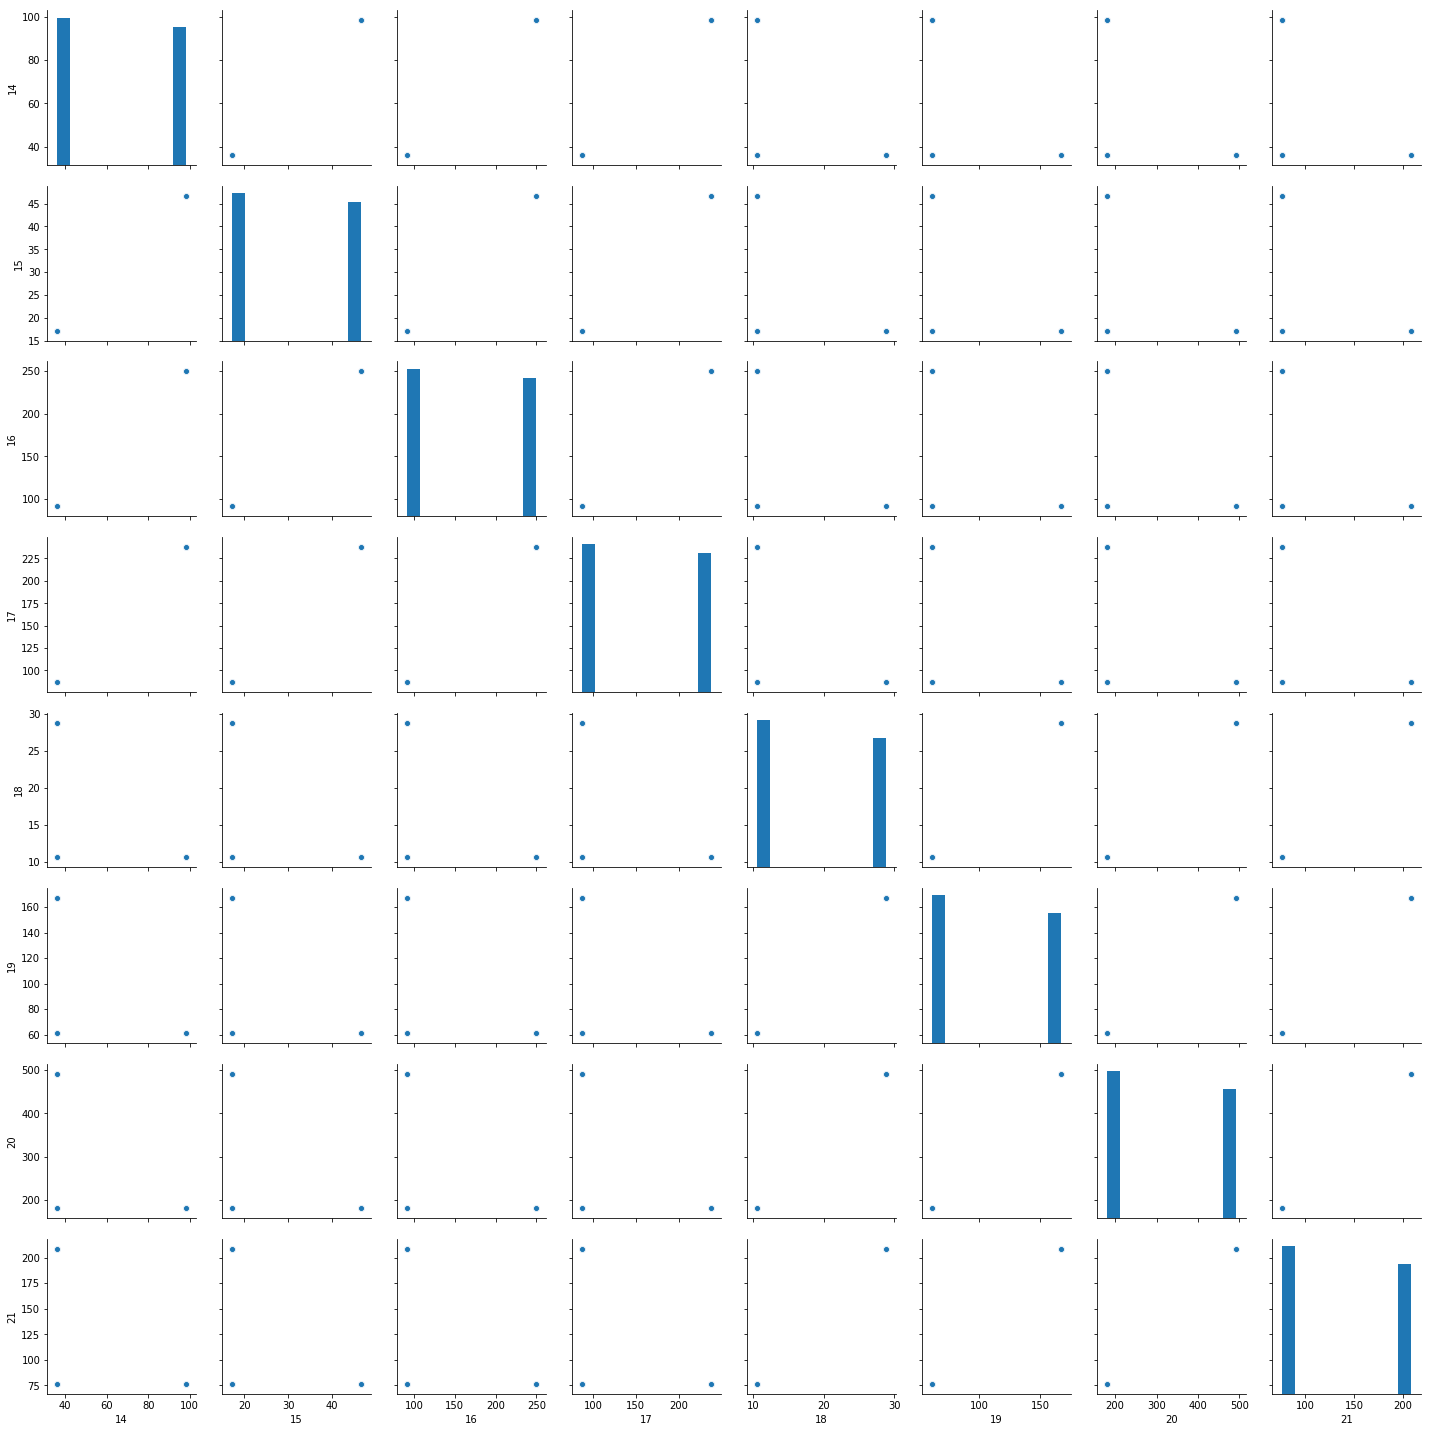

In [36]:
sns.pairplot(X_train[[14, 15, 16, 17, 18, 19, 20, 21]])

In [37]:
X_train[[14, 15, 16, 17, 18, 19, 20, 21]].corr()

,14,15,16,17,18,19,20,21
14,1.00000,1.00000,1.00000,1.00000,-0.90779,-0.90779,-0.90779,-0.90779
15,1.00000,1.00000,1.00000,1.00000,-0.90779,-0.90779,-0.90779,-0.90779
16,1.00000,1.00000,1.00000,1.00000,-0.90779,-0.90779,-0.90779,-0.90779
17,1.00000,1.00000,1.00000,1.00000,-0.90779,-0.90779,-0.90779,-0.90779
18,-0.90779,-0.90779,-0.90779,-0.90779,1.00000,1.00000,1.00000,1.00000
19,-0.90779,-0.90779,-0.90779,-0.90779,1.00000,1.00000,1.00000,1.00000
20,-0.90779,-0.90779,-0.90779,-0.90779,1.00000,1.00000,1.00000,1.00000
21,-0.90779,-0.90779,-0.90779,-0.90779,1.00000,1.00000,1.00000,1.00000


In [38]:
delete = np.append(delete, [15, 16, 17, 18, 19, 20, 21])
#X_train.drop(columns=[15, 16, 17, 18, 19, 20, 21], inplace=True)
#X_test.drop(columns=[15, 16, 17, 18, 19, 20, 21], inplace=True)

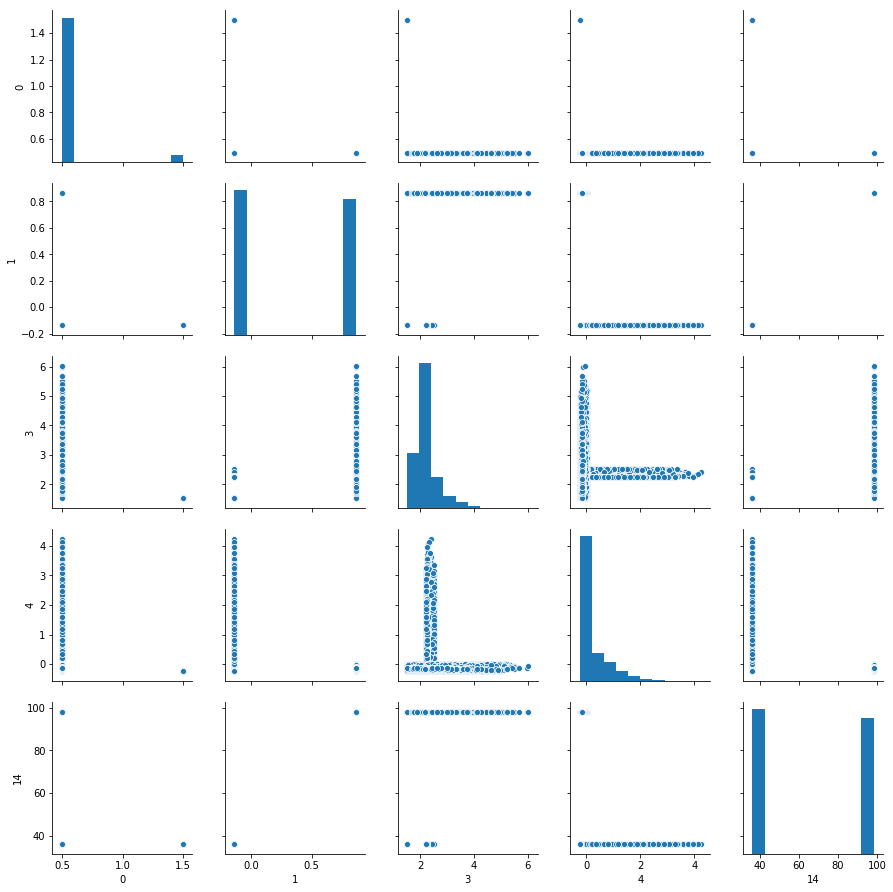

In [39]:
sns.pairplot(X_train[[0, 1, 3, 4, 14]])

Закодируем первые 2 признака и 14 признак с помощью 0 и 1:

In [40]:
X_train[0] -= set(X_train[0]).pop()
X_train[1] -= set(X_train[1]).pop()

In [41]:
X_train[14] = (X_train[14].values > 40).astype(float)

In [42]:
set(X_train[0]), set(X_train[1]), set(X_train[14])

({0.0, 1.0}, {0.0, 1.0}, {0.0, 1.0})

In [43]:
X_train.corr()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1.000000e+00,-2.183166e-01,-2.111227e-01,-3.750031e-01,-1.877822e-01,1.000000e+00,-2.183166e-01,-2.111227e-01,-3.750031e-01,-1.877822e-01,...,-1.746708e-01,-1.043911e-01,-1.043911e-01,-1.043911e-01,-1.043911e-01,2.176042e-13,1.482147e-13,-1.255597e-13,-5.440143e-14,-6.064583e-13
1,-2.183166e-01,1.000000e+00,-9.077897e-01,8.029372e-02,-5.425235e-01,-2.183166e-01,1.000000e+00,-9.077897e-01,8.029372e-02,-5.425235e-01,...,1.784766e-01,-3.700386e-01,-3.700386e-01,-3.700386e-01,-3.700386e-01,-3.148196e-13,1.588747e-13,-2.249770e-14,-4.608366e-13,-4.231586e-13
2,-2.111227e-01,-9.077897e-01,1.000000e+00,8.074992e-02,6.241103e-01,-2.111227e-01,-9.077897e-01,1.000000e+00,8.074992e-02,6.241103e-01,...,-1.036935e-01,4.155049e-01,4.155049e-01,4.155049e-01,4.155049e-01,3.871803e-12,4.655086e-12,-4.702991e-12,4.142218e-12,-4.278616e-12
3,-3.750031e-01,8.029372e-02,8.074992e-02,1.000000e+00,7.113173e-02,-3.750031e-01,8.029372e-02,8.074992e-02,1.000000e+00,7.113173e-02,...,8.523566e-01,3.964092e-02,3.964092e-02,3.964092e-02,3.964092e-02,3.283064e-12,3.158751e-12,-3.202994e-12,3.184638e-12,-3.290426e-12
4,-1.877822e-01,-5.425235e-01,6.241103e-01,7.113173e-02,1.000000e+00,-1.877822e-01,-5.425235e-01,6.241103e-01,7.113173e-02,1.000000e+00,...,-5.358517e-02,8.720051e-01,8.720051e-01,8.720051e-01,8.720051e-01,8.880405e-14,5.396670e-14,-4.509423e-14,6.561206e-14,-8.289402e-14
5,1.000000e+00,-2.183166e-01,-2.111227e-01,-3.750031e-01,-1.877822e-01,1.000000e+00,-2.183166e-01,-2.111227e-01,-3.750031e-01,-1.877822e-01,...,-1.746708e-01,-1.043911e-01,-1.043911e-01,-1.043911e-01,-1.043911e-01,-5.735805e-14,-1.511660e-13,2.453062e-14,-2.726212e-13,7.803390e-13
6,-2.183166e-01,1.000000e+00,-9.077897e-01,8.029372e-02,-5.425235e-01,-2.183166e-01,1.000000e+00,-9.077897e-01,8.029372e-02,-5.425235e-01,...,1.784766e-01,-3.700386e-01,-3.700386e-01,-3.700386e-01,-3.700386e-01,2.957697e-12,3.480650e-12,-3.437831e-12,3.893231e-12,-3.691927e-12
7,-2.111227e-01,-9.077897e-01,1.000000e+00,8.074992e-02,6.241103e-01,-2.111227e-01,-9.077897e-01,1.000000e+00,8.074992e-02,6.241103e-01,...,-1.036935e-01,4.155049e-01,4.155049e-01,4.155049e-01,4.155049e-01,-2.423688e-12,-1.897749e-12,2.610994e-12,-1.674692e-12,1.587060e-12
8,-3.750031e-01,8.029372e-02,8.074992e-02,1.000000e+00,7.113173e-02,-3.750031e-01,8.029372e-02,8.074992e-02,1.000000e+00,7.113173e-02,...,8.523566e-01,3.964092e-02,3.964092e-02,3.964092e-02,3.964092e-02,1.010260e-13,1.475432e-13,-8.472649e-14,6.062543e-14,-2.583678e-14
9,-1.877822e-01,-5.425235e-01,6.241103e-01,7.113173e-02,1.000000e+00,-1.877822e-01,-5.425235e-01,6.241103e-01,7.113173e-02,1.000000e+00,...,-5.358517e-02,8.720051e-01,8.720051e-01,8.720051e-01,8.720051e-01,-3.160997e-14,-2.861247e-14,3.854826e-14,-1.763763e-14,-2.420095e-15


In [44]:
delete = np.append(delete, 14)

In [45]:
X_copy = X_train.copy()
X_train.drop(columns=delete, inplace=True)
X_test.drop(columns=delete, inplace=True)

In [46]:
X_int = copy.copy(X_train.values)
y_int = copy.copy(y_train.values)

#### Нормализация и выбросы:

In [47]:
X_train = pd.DataFrame(preprocessing.minmax_scale(X_train)) # не уверена, что надо делать
X_test = pd.DataFrame(preprocessing.minmax_scale(X_test))

In [48]:
X_train.describe()

,0,1,2,3
count,172744.000000,172744.000000,172744.000000,172744.000000
mean,0.048320,0.484196,0.168119,0.098992
std,0.214442,0.499752,0.101019,0.118786
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.121050,0.024787
50%,0.000000,0.000000,0.169556,0.046071
75%,0.000000,1.000000,0.193093,0.138672
max,1.000000,1.000000,1.000000,1.000000


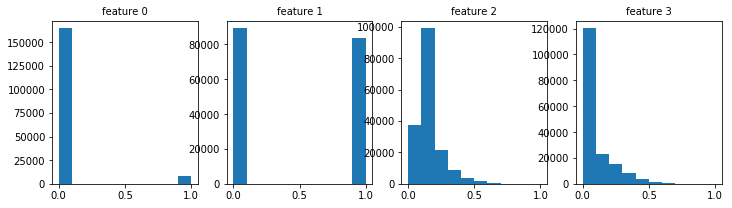

In [49]:
cols = X_train.columns
fig, axs = plt.subplots(1, len(cols), figsize=(3*len(cols), 3))
for i in range(len(cols)):
    axs[i].hist(X_train[cols[i]].values)
    axs[i].set_title('feature '+str(cols[i]), fontsize=10)

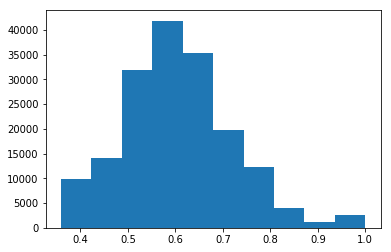

(array([ 7195.,  4357., 12755., 25896., 36431., 39088., 24774., 15326.,
         3714.,  3208.]),
 array([-1.02513282, -0.92261954, -0.82010626, -0.71759297, -0.61507969,
        -0.51256641, -0.41005313, -0.30753985, -0.20502656, -0.10251328,
         0.        ]),
 <a list of 10 Patch objects>)

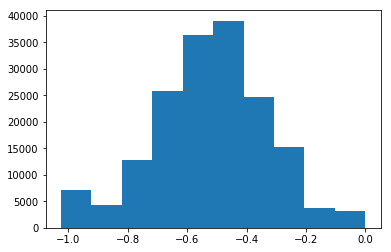

In [50]:
plt.hist(y_train.values)
plt.show()
plt.hist(np.log(y_train.values))

In [51]:
np.max(y_train.values)/np.min(y_train.values)

2.7874656661040995

Преобразование Бокса-Кокса:

In [52]:
log_y = st.boxcox(y_train, 0).reshape(-1,1)
old_columns = list(y_train.columns)
y_train = pd.concat([y_train.reset_index(drop=True), pd.Series(log_y.flatten())], ignore_index=True, axis=1, join='outer')
y_train.columns=list(old_columns)+['log_y']
y_train.head()

,0,log_y
0,0.658741,-0.417426
1,0.671523,-0.398208
2,0.660211,-0.415195
3,0.662597,-0.411589
4,0.658827,-0.417294


(array([ 7195.,  4357., 12755., 25896., 36431., 39088., 24774., 15326.,
         3714.,  3208.]),
 array([-1.02513282, -0.92261954, -0.82010626, -0.71759297, -0.61507969,
        -0.51256641, -0.41005313, -0.30753985, -0.20502656, -0.10251328,
         0.        ]),
 <a list of 10 Patch objects>)

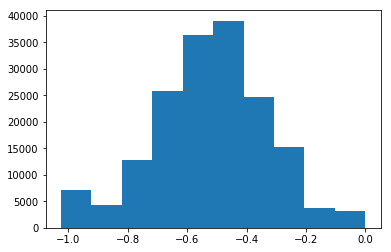

In [53]:
plt.hist(log_y)

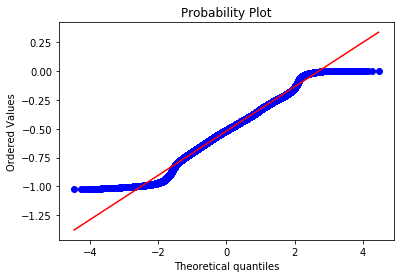

In [54]:
qq_points, qq_line = st.probplot(log_y.ravel(), plot=plt)

### Модель:

In [55]:
X_train = X_train.join(y_train['log_y'])
X_train.columns = ['f0', 'f1', 'f2', 'f3', 'log_y']
X_test.columns = ['f0', 'f1', 'f2', 'f3']

In [56]:
model = sm.OLS.from_formula('log_y~f0 + f1 + f2 + f3', X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  log_y   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                 1.179e+05
Date:                Sat, 27 Apr 2019   Prob (F-statistic):               0.00
Time:                        22:53:46   Log-Likelihood:             1.5294e+05
No. Observations:              172744   AIC:                        -3.059e+05
Df Residuals:                  172739   BIC:                        -3.058e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3898      0.001   -529.094      0.000      -0.391      -0.388
f0            -0.5720      0.001   -433.998      0.000      -0.575      -0.569
f1            -0.2581      0.001   -415.836      0.000      -0.259      -0.257
f2             0.0858      0.003     33.435      0.000       0.081       0.091
f3             0.0747      0.003     28.771      0.000       0.070       0.080
==============================================================================
Omnibus:                     7924.361   Durbin-Watson:                   0.683
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10865.358
Skew:                           0.451   Prob(JB):                         0.00
Kurtosis:                       3.833   Cond. No.                         13.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Проверим на обучающей выборке:

In [57]:
y_pred = results.predict(X_train)

In [58]:
mean_absolute_error(y_pred, y_train['log_y'].values)/abs(np.mean(y_train['log_y'])), \
mean_squared_error(y_pred, y_train['log_y'].values)/abs(np.mean(y_train['log_y']))

(0.15301934466688752, 0.019140346463161248)

In [59]:
mean_absolute_error(np.exp(y_pred), y_train[0].values)/abs(np.mean(y_train[0])), \
mean_squared_error(np.exp(y_pred), y_train[0].values)/abs(np.mean(y_train[0]))

(0.08188298393607948, 0.00718574435907019)

Ошибка на обучающей выборке не слишком большая.

In [60]:
y_pred = get_image(286, 604, np.exp(results.predict(X_train).values))

In [61]:
y_train_image = get_image(286, 604, y_train[0].values).reshape((286, 604))

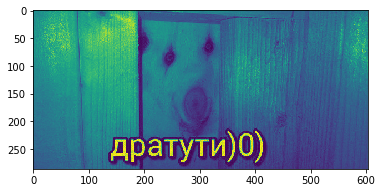

In [62]:
imshow(y_train_image) # я не смогла сделать ее не синей =(

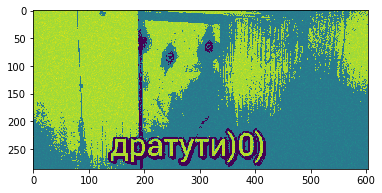

In [63]:
imshow(np.asarray(y_pred))

### Восстановим изображение:

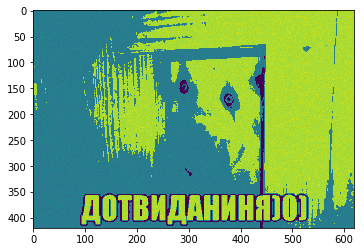

In [64]:
y_test = get_image(420, 620, np.exp(results.predict(X_test).values))
imshow(np.asarray(y_test))

#### Попробуем добавить коррелированные признаки:

In [65]:
X_train.head()

,f0,f1,f2,f3,log_y
0,0.0,0.0,0.169977,0.244453,-0.417426
1,0.0,0.0,0.171111,0.034534,-0.398208
2,0.0,0.0,0.171675,0.330331,-0.415195
3,0.0,0.0,0.171675,0.212086,-0.411589
4,0.0,0.0,0.169977,0.146692,-0.417294


In [66]:
X_train['f4'] = X_copy[2]

model = sm.OLS.from_formula('log_y~f0 + f1 + f2 + f3 + f4', X_train)
results = model.fit()

y_pred = results.predict(X_train)
mean_absolute_error(np.exp(y_pred), y_train[0].values)/abs(np.mean(y_train[0])), \
mean_squared_error(np.exp(y_pred), y_train[0].values)/abs(np.mean(y_train[0]))

(0.08189555324636494, 0.007184581794180896)

In [67]:
X_train['f5'] = X_copy[22]

model = sm.OLS.from_formula('log_y~f0 + f1 + f2 + f3 + f5', X_train)
results = model.fit()

y_pred = results.predict(X_train)
mean_absolute_error(np.exp(y_pred), y_train[0].values)/abs(np.mean(y_train[0])), \
mean_squared_error(np.exp(y_pred), y_train[0].values)/abs(np.mean(y_train[0]))

(0.08168414245367647, 0.007144685350420636)

In [68]:
X_train['f6'] = X_copy[26]

model = sm.OLS.from_formula('log_y~f0 + f1 + f2 + f3 + f6', X_train)
results = model.fit()

y_pred = results.predict(X_train)
mean_absolute_error(np.exp(y_pred), y_train[0].values)/abs(np.mean(y_train[0])), \
mean_squared_error(np.exp(y_pred), y_train[0].values)/abs(np.mean(y_train[0]))

(0.08156037620268455, 0.007171437472107719)

In [ ]:
model = sm.OLS.from_formula('log_y~f0 + f1 + f2 + f3 + f4 + f5 + f6', X_train)
results = model.fit()

y_pred = results.predict(X_train)
mean_absolute_error(np.exp(y_pred), y_train[0].values)/abs(np.mean(y_train[0])), \
mean_squared_error(np.exp(y_pred), y_train[0].values)/abs(np.mean(y_train[0]))

(0.08137727022703885, 0.00712915947195683)

In [ ]:
y_pred = get_image(286, 604, np.exp(results.predict(X_train).values))
y_train_image = get_image(286, 604, y_train[0].values).reshape((286, 604))

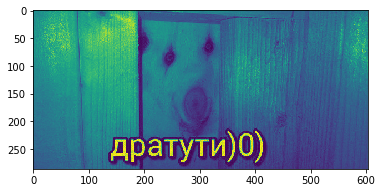

In [ ]:
imshow(y_train_image)

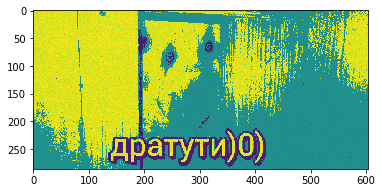

In [ ]:
imshow(np.asarray(y_pred))

### Интерпретация признаков:

Группы признаков с высокой и абсолютной корреляцией:
1. 30-34: константы.
2. 0, 5, 10, 11, 12, 13 (признак f0) - бинарные признаки.
3. 3, 8, 22-25 (признак f2) - 98899 различных значений.
4. 4, 9, 26-29 (признак f3) - 100611 различных значений.
5. 1, 2, 6, 7, 14-21 (признак f1) - бинарные признаки.

Проинтерпретируем по одному из каждой группы.

In [ ]:
X_train.head()

,f0,f1,f2,f3,log_y,f4,f5,f6
0,0.0,0.0,0.169977,0.244453,-0.417426,1.647689,6.467641,45.607623
1,0.0,0.0,0.171111,0.034534,-0.398208,1.647689,6.500748,17.831804
2,0.0,0.0,0.171675,0.330331,-0.415195,1.647689,6.517282,66.970839
3,0.0,0.0,0.171675,0.212086,-0.411589,1.647689,6.517282,39.459637
4,0.0,0.0,0.169977,0.146692,-0.417294,1.647689,6.467641,29.451076


In [ ]:
print(X_int)#0, 1, 3, 4
print(y_int)
#без преобразований

[[ 0.          0.          2.288549    0.85943114]
 [ 0.          0.          2.29365473 -0.07966015]
 [ 0.          0.          2.29619496  1.24361355]
 ...
 [ 0.          1.          2.45612095 -0.14779807]
 [ 0.          1.          1.89287071 -0.14547789]
 [ 0.          1.          2.64300213 -0.14312694]]
[[0.65874055]
 [0.67152252]
 [0.66021125]
 ...
 [0.49081787]
 [0.49068043]
 [0.50617512]]


In [ ]:
X0_1 = (X_int[:,0] == 1)
X0_0 = (X_int[:,0] == 0)
print(y_int[X0_1].min(), y_int[X0_1].max())
print(y_int[X0_0].min(), y_int[X0_0].max())

0.35874881336122416 0.41633493814679146
0.3930133275061599 1.0


In [ ]:
X1_1 = (X_int[:,1] == 1)
X1_0 = (X_int[:,1] == 0)
print(y_int[X1_1].min(), y_int[X1_1].max())
print(y_int[X1_0].min(), y_int[X1_0].max())

0.3930133275061599 0.6247128130687505
0.35874881336122416 1.0


2685


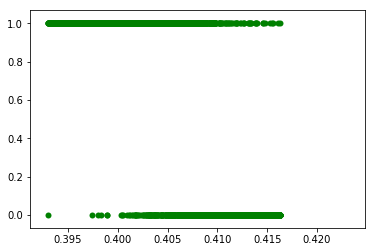

In [ ]:
s=0
Min = y_int[X0_0].min()
Max = y_int[X0_1].max()
for k in range(0, len(X_int)):
    if (Min <= y_int[k] <= Max): 
        plt.scatter(y_int[k], X_int[k,0], lw=0, color = 'green')#, alpha = 1)
        s += 1
print(s)

In [ ]:
plt.scatter(y_int, X_int[:,1], lw=0, color = 'green')

In [ ]:
plt.scatter(y_int, X_int[:,2], lw=0, color = 'green')
plt.xlabel('y')
plt.ylabel('f3')

In [ ]:
plt.scatter(y_int[k], X_int[:,2], lw=0, color = 'green')
plt.xlabel('y')
plt.ylabel('f4')

#### Вывод
Признак 0 достаточно хорошо интерпретируется как индикатор перехода значением пикселя некоторого порога, лежащего в диапазоне [0.393; 0.416]. Оценим этот порог как среднее арифметическое: 0.405.

При этом, если значение находится в данном интервале, то признак оказывается шумовым. Ниже 0.393 определяется значение 0, выше - 1.

Признак 1. при y>0.625 или y<0.393 - точно 0; 0.393<y<0.595 - точно 1; при 0.595<y<0.625 - шум.

Признак 3. Как показывает график, при y>0.62 зависимость f3 от y является с хорошей точностью (оценка по графику) линейной; в среднем f3=y+1.625. При y<0.62 признак является шумовым.

Признак 4 является шумовым при y>0.58. При y<0.58 обнаружена зависимость, которая очевидно отклоняется от линейной.